In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import os
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm

%matplotlib inline

C:\Users\b_luo\AppData\Local\Continuum\anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Load and transform data

In [2]:
taxonGenePairs = {}
alreadySeenPairs = set()
    
inFile = open("../data/Scores_Sizes.txt")
for line in inFile:
    if "Score" not in line:
        data = line.strip().split("\t")
        gene = int(data[1])
        taxon = int(data[4])
        
        if gene != 0:
            gene = math.log(gene)
        else:
            gene = -1e6
        
        if taxon != 0:
            taxon = math.log(taxon)
        else:
            taxon = -1e6
        
        pair = (taxon, gene)
        score = float(data[6])
        if score != 0:
            scoreLog = math.log(score)
        else: 
            scoreLog = -1e6
        if pair not in alreadySeenPairs:
            taxonGenePairs[pair] = [score, scoreLog, 1.0]
            alreadySeenPairs.add(pair)
        else:
            prevScoreCount = taxonGenePairs.get(pair)
            taxonGenePairs[pair] = [prevScoreCount[0] + score, prevScoreCount[1]+scoreLog, prevScoreCount[2] + 1.0]

for key in taxonGenePairs:
    scoreAndCount = taxonGenePairs.get(key)
    taxonGenePairs[key] =[scoreAndCount[0]/scoreAndCount[2], scoreAndCount[1]/scoreAndCount[2],scoreAndCount[2] ]

inFile.close()

In [3]:
taxonLogGeneLogAvgCombo = pd.DataFrame(taxonGenePairs.items(), columns=['taxonAndGeneLog','scoreSummary' ])

taxonLogGeneLogAvgCombo[['taxonLogCombo', 'geneLogCombo']] = taxonLogGeneLogAvgCombo['taxonAndGeneLog'].apply(pd.Series)
taxonLogGeneLogAvgCombo[['scoreCombo','scoreLogCombo','count']] = taxonLogGeneLogAvgCombo['scoreSummary'].apply(pd.Series)
taxonLogGeneLogAvgCombo.drop(['taxonAndGeneLog'], axis=1, inplace=True)
taxonLogGeneLogAvgCombo.drop(['scoreSummary'], axis=1, inplace=True)

taxonLogGeneLogAvgCombo.head()

,taxonLogCombo,geneLogCombo,scoreCombo,scoreLogCombo,count
0,4.043051,5.043425,0.639043,-0.500247,4.0
1,4.382027,4.927254,1.028884,0.028140,2.0
2,5.463832,4.369448,1.075032,0.064724,11.0
3,2.564949,4.828314,0.684131,-0.449291,30.0
4,6.188264,4.553877,1.153085,0.133500,8.0


# OLS Multi Regression: Log(Taxon) + Log(Gene) vs. Average Score of Combo

Now, we'll try a multiple regression using Log(Taxon) and Log(Gene) and the average of all scores associated with each pair.

In [4]:
resultsTaxonLogGeneLogAvgCombo = smf.ols(formula='scoreCombo ~ taxonLogCombo + geneLogCombo', data=taxonLogGeneLogAvgCombo).fit()
print(resultsTaxonLogGeneLogAvgCombo.summary())

                            OLS Regression Results                            
Dep. Variable:             scoreCombo   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                 4.591e+04
Date:                Tue, 03 Apr 2018   Prob (F-statistic):               0.00
Time:                        13:59:20   Log-Likelihood:                 17435.
No. Observations:               32683   AIC:                        -3.486e+04
Df Residuals:                   32680   BIC:                        -3.484e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.6007      0.005   -126.501

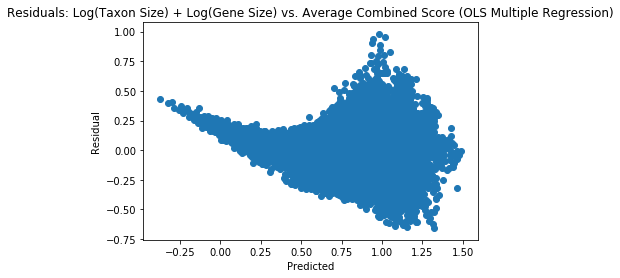

In [5]:
residualsTaxonLogGeneLogAvgCombo = []
actualTaxonLogGeneLogAvgCombo = list(taxonLogGeneLogAvgCombo.scoreCombo)
predictedTaxonLogGeneLogAvgCombo = resultsTaxonLogGeneLogAvgCombo.fittedvalues

for x in range(0, len(actualTaxonLogGeneLogAvgCombo)):
    actualScore = actualTaxonLogGeneLogAvgCombo[x]
    predictedScore = predictedTaxonLogGeneLogAvgCombo[x]
    residual = actualScore - predictedScore
    residualsTaxonLogGeneLogAvgCombo.append(residual)
    
plt.scatter(np.array(predictedTaxonLogGeneLogAvgCombo), np.array(residualsTaxonLogGeneLogAvgCombo))
plt.title('Residuals: Log(Taxon Size) + Log(Gene Size) vs. Average Combined Score (OLS Multiple Regression)')
plt.xlabel('Predicted')
plt.ylabel('Residual')

# WLS Multi Regression: Log(Taxon) + Log(Gene) vs. Average Score of Combo with $weight = n_i$

In [6]:
y=taxonLogGeneLogAvgCombo.scoreCombo
X=taxonLogGeneLogAvgCombo.loc[:,['taxonLogCombo','geneLogCombo']]
X = sm.add_constant(X)
wlsResultsTaxonLogGeneLogAvgCombo=smf.WLS(y,X,weights=taxonLogGeneLogAvgCombo.loc[:,'count']).fit()
print(wlsResultsTaxonLogGeneLogAvgCombo.summary())

                            WLS Regression Results                            
Dep. Variable:             scoreCombo   R-squared:                       0.856
Model:                            WLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                 9.716e+04
Date:                Tue, 03 Apr 2018   Prob (F-statistic):               0.00
Time:                        13:59:21   Log-Likelihood:                -1721.2
No. Observations:               32683   AIC:                             3448.
Df Residuals:                   32680   BIC:                             3474.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.2046      0.001   -155.916

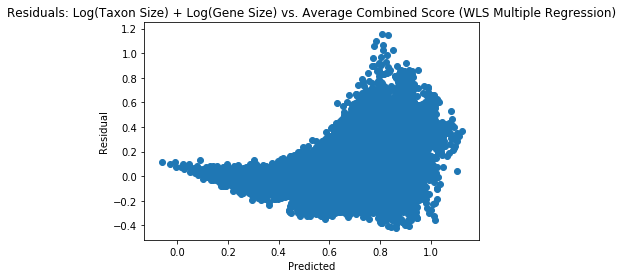

In [7]:
wlsResidualsTaxonLogGeneLogAvgCombo = []
wlsActualTaxonLogGeneLogAvgCombo = list(taxonLogGeneLogAvgCombo.scoreCombo)
wlsPredictedTaxonLogGeneLogAvgCombo = wlsResultsTaxonLogGeneLogAvgCombo.fittedvalues

for x in range(0, len(wlsActualTaxonLogGeneLogAvgCombo)):
    actualScore = wlsActualTaxonLogGeneLogAvgCombo[x]
    predictedScore = wlsPredictedTaxonLogGeneLogAvgCombo[x]
    residual = actualScore - predictedScore
    wlsResidualsTaxonLogGeneLogAvgCombo.append(residual)
    
plt.scatter(np.array(wlsPredictedTaxonLogGeneLogAvgCombo), np.array(wlsResidualsTaxonLogGeneLogAvgCombo))
plt.title('Residuals: Log(Taxon Size) + Log(Gene Size) vs. Average Combined Score (WLS Multiple Regression)')
plt.xlabel('Predicted')
plt.ylabel('Residual')